### Solve 2959 using reordering of equations

This notebook solves SAT for https://github.com/VeriFIT/smt-bench/blob/master/formulae/slog/slog_stranger_2959_sink.smt2 manually using algos from Noodler and by modifying the original equation system into an equivalent one.

In [1]:
import noodler

In [2]:
filename = "../benchmarks/slog/slog_stranger_2959_sink.smt2"
parser = noodler.parser.SmtlibParserHackAbc(filename)
orig = parser.parse_query()

Here is the list of equations and graph showing dependencies between variables. In the following, we rewrite the equations highlighted with the green box into one equation and try to solve it in one shot.

In [4]:
graph = '<img src="Dependency-graph.png" alt="Drawing" style="width: 300px;"/>'
eq_str = "<br />".join([e.__str__() for e in orig.equations])

noodler.utils.display_inline(eq_str, graph, per_row=2)

In [5]:
orig.aut_constraints["literal_35"].display()

We change the order based on the graph (and on the number of noodles as well) to 16-15-**13-11-14-12-10**-9-...

In [6]:
new_eqs = orig.equations.copy()
new_eqs[14] = orig.equations[13]
new_eqs[13] = orig.equations[11]
new_eqs[12] = orig.equations[14]
new_eqs[11] = orig.equations[12]
reordered_q = noodler.MultiSEQuery(new_eqs, orig.aut_constraints)
display(reordered_q.equations)
noodler.is_straightline(reordered_q.equations)

[StringEquation: ['x_8'] = ['literal_7', 'sigmaStar_2'],
 StringEquation: ['x_10'] = ['x_8', 'literal_9'],
 StringEquation: ['x_12'] = ['x_10', 'sigmaStar_1'],
 StringEquation: ['x_15'] = ['x_12', 'literal_13'],
 StringEquation: ['x_17'] = ['x_15', 'sigmaStar_6'],
 StringEquation: ['x_21'] = ['x_17', 'literal_19'],
 StringEquation: ['x_24'] = ['x_21', 'literal_18'],
 StringEquation: ['x_25'] = ['x_24', 'literal_23'],
 StringEquation: ['x_26'] = ['literal_22', 'x_25'],
 StringEquation: ['x_29'] = ['x_26', 'literal_27'],
 StringEquation: ['x_31'] = ['x_29', 'x_25'],
 StringEquation: ['x_34'] = ['x_31', 'literal_32'],
 StringEquation: ['x_37'] = ['x_34', 'x_25'],
 StringEquation: ['x_33'] = ['literal_30', 'x_25'],
 StringEquation: ['x_36'] = ['x_33', 'literal_35'],
 StringEquation: ['x_39'] = ['x_37', 'x_36'],
 StringEquation: ['x_41'] = ['x_39', 'literal_40']]

True

In [7]:
%%timeit
machine = noodler.noodler.StraightlineNoodleMachine(reordered_q)
machine.is_sat()

1.03 s ± 59.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
machine_r = noodler.noodler.StraightlineNoodleMachine(reordered_q)
machine_r.is_sat(verbose=True)

====EQUATIONS====
0: ['x_8'] = ['literal_7', 'sigmaStar_2']
1: ['x_10'] = ['x_8', 'literal_9']
2: ['x_12'] = ['x_10', 'sigmaStar_1']
3: ['x_15'] = ['x_12', 'literal_13']
4: ['x_17'] = ['x_15', 'sigmaStar_6']
5: ['x_21'] = ['x_17', 'literal_19']
6: ['x_24'] = ['x_21', 'literal_18']
7: ['x_25'] = ['x_24', 'literal_23']
8: ['x_26'] = ['literal_22', 'x_25']
9: ['x_29'] = ['x_26', 'literal_27']
10: ['x_31'] = ['x_29', 'x_25']
11: ['x_34'] = ['x_31', 'literal_32']
12: ['x_37'] = ['x_34', 'x_25']
13: ['x_33'] = ['literal_30', 'x_25']
14: ['x_36'] = ['x_33', 'literal_35']
15: ['x_39'] = ['x_37', 'x_36']
16: ['x_41'] = ['x_39', 'literal_40']
====Constraints` sizes====
x_41: 9 states, 1 final
literal_7: 98 states, 1 final
literal_9: 24 states, 1 final
literal_13: 41 states, 1 final
literal_19: 35 states, 1 final
literal_18: 13 states, 1 final
literal_23: 78 states, 1 final
literal_22: 100 states, 1 final
literal_27: 16 states, 1 final
literal_30: 14 states, 1 final
literal_32: 10 states, 1 final

True

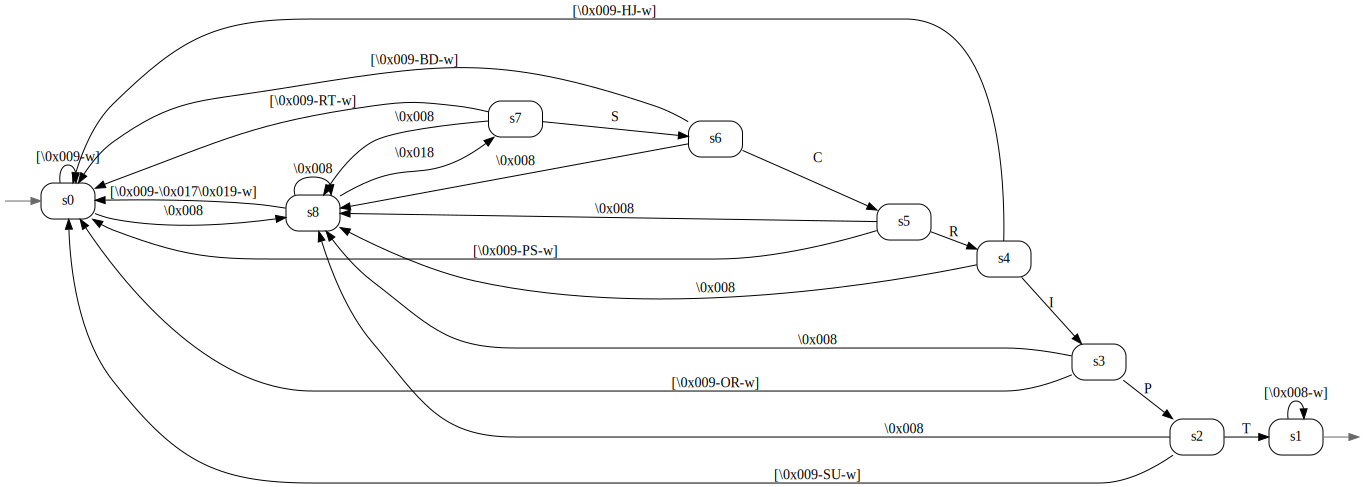

In [9]:
n = machine_r.noodlers[0]
n.query.constraints["x_25"].display()

In [10]:
def merge_equations(query, substitute_ids):
    """
    Remove (by substitution) equations from MultiSEQuery.
    
    Builds an equivalent query to ``query`` that does not contain
    equations given by ids in ``substitute_ids``. These equations
    must be assignments (e.g. of the form `xᵢ = y₁y₂...`). To maintain
    equivalence, all occurences of `xᵢ` are substituted with `y₁y₂...`
    and the constraints (if not equivalent to Σ*) are propagated to
    constraints for the corresponding (left-side) variables.
    
    Correct for straightline fragment.
    
    TODO
    ----
    propagate constraints
    
    Returns
    -------
    MultiSEQuery equivalent to ``query`.
    """
    # Check that all equations are assignments
    # and that the corresponding constraints are Σ*
    for eq_id in substitute_ids:
        eq = query.equations[eq_id]
        assert len(eq.left) == 1 # assignment
        
        var = eq.left[0]
        constr = query.aut_constraints[var]
        assert constr.num_useful_states() == 1
        assert len(constr.final_states()) == 1
    
    substitute_vars = [query.equations[eq_id].left[0] for eq_id in substitute_ids]
    
    # Copy usable parts
    working_eq = [noodler.StringEquation(eq.left, eq.right.copy()) for eq in query.equations]
    res_eq = []
    res_constr = {var : query.aut_constraints[var].copy() for var in query.aut_constraints if var not in substitute_vars}
    
    # Substitute
    for eq_id in range(len(working_eq)):
        eq = working_eq[eq_id]
        # If not to removed, add to result
        if eq_id not in substitute_ids:
            res_eq.append(eq)
            continue
        
        # Else substitute
        var, right = eq.left[0], eq.right
        for succ_i  in range(eq_id+1, len(working_eq)):
            succ_eq = working_eq[succ_i]
            if var not in succ_eq.right:
                continue
            # Else substitute `right` for var
            new_succ_right = []
            for v in succ_eq.right:
                if v == var:
                    new_succ_right.extend(right)
                else:
                    new_succ_right.append(v)
            working_eq[succ_i] = noodler.StringEquation(succ_eq.left, new_succ_right)
            
q3 = merge_equations(reordered_q, [13])

In [11]:
%%timeit
machine = noodler.noodler.StraightlineNoodleMachine(q3)
machine.is_sat()

AttributeError: 'NoneType' object has no attribute 'equations'

In [ ]:
machine_merged = noodler.noodler.StraightlineNoodleMachine(q3)
machine_merged.is_sat(verbose=True)

In [ ]:
n = machine_merged.noodlers[0]
n.query.constraints["x_25"].display()